# Scratch

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap, random, lax
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp

import utils
import metrics
import time
import plot
import svgd

rkey = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# test train

In [2]:
dist = metrics.Gaussian(0, 1)
svgd = svgd.SVGD(dist, 300)

In [3]:
h = 1
meta_stepsize = 0.1
svgd_stepsize = 0.1
n_steps = 300
x, log = svgd.train(rkey, h, meta_stepsize, svgd_stepsize, n_steps)

JIT COMPILING step...
...done compiling step after 0.17820215225219727 seconds.
JIT COMPILING step...
...done compiling step after 0.005154609680175781 seconds.


In [21]:
x = svgd.initialize(rkey)
x, h, l = svgd.step(x, h, meta_stepsize, svgd_stepsize)

In [22]:
h

DeviceArray(1., dtype=float32)

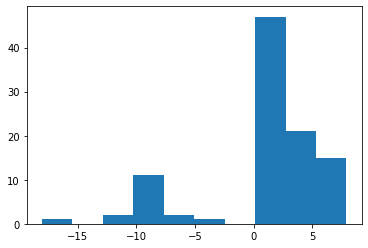

In [5]:
_ = plt.hist(x[:, 0])

## test mixture

In [139]:
d = 3
k = 5
rkey = random.split(rkey)[0]
means = random.uniform(rkey, shape=(k, d))
covs = random.uniform(rkey, shape=(k, d, d))
covs = np.einsum("kil,kjl->kij", covs, covs)
weights = np.array([1/3, 2/3, 2/3, 2/3, 1/3])

mix = metrics.GaussianMixture(means, covs, weights)

In [147]:
diffs = []
grid = np.arange(15)
grid = 3**grid
for i in grid:
    sample = mix.sample(shape=(i,))
    diffs.append(np.mean((np.cov(sample, rowvar=False) - mix.cov)**2 / mix.cov))
diffs = np.array(diffs)

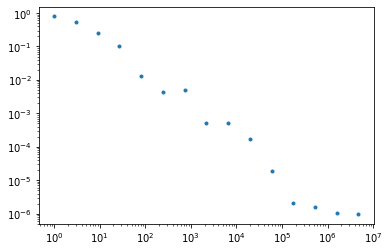

In [150]:
plt.plot(grid, diffs, ".")
plt.yscale("log")
plt.xscale("log")

## test Gaussian

In [2]:
mean = np.array([1, 2])
cov = np.array([[1, 3], [3, 20]])

In [3]:
gauss = metrics.Gaussian(mean, cov)

In [4]:
metrics.Distribution

metrics.Distribution

In [12]:
sample = gauss.sample(shape=(100,))
rsample = random.multivariate_normal(rkey, mean*3, cov/2, shape=(100,))

In [13]:
gauss.compute_metrics(sample)

{'square_errors': DeviceArray([[2.1377051e-05, 1.1094661e-01],
              [5.0606076e-02, 1.2406965e+01],
              [1.3029933e-01, 2.5386177e-04],
              [3.2070032e-01, 1.6137745e-02]], dtype=float32),
 'ksds': [DeviceArray(194.03964, dtype=float32),
  DeviceArray(4.402493, dtype=float32),
  DeviceArray(0.9635019, dtype=float32)]}

In [8]:
gauss.compute_metrics(rsample)

{'square_errors': DeviceArray([[4.0129423e+00, 1.9340918e+01],
              [5.6845673e+01, 7.7879669e+02],
              [5.7990074e-01, 2.1410324e-05],
              [7.9445569e-03, 3.1765524e-02]], dtype=float32),
 'ksds': [DeviceArray(221.5557, dtype=float32),
  DeviceArray(112.118126, dtype=float32),
  DeviceArray(541.3391, dtype=float32)]}

## jax einsum floating point round-off error

In [24]:
import jax.numpy as jnp
import numpy as onp

Jax

In [60]:
values = jnp.array([[-5], [10]])
weights = jnp.array([1/3, 2/3])

In [61]:
jnp.einsum("i,id->d", weights, values)

DeviceArray([5.0000005], dtype=float32)

In [62]:
jnp.sum(values.flatten() * weights)

DeviceArray(5., dtype=float32)

Numpy

In [50]:
values = onp.array([[-5], [10]], dtype=np.float32)
weights = onp.array([1/3, 2/3], dtype=np.float32)

In [51]:
onp.einsum("i,id->d", weights, values)

array([5.], dtype=float32)